In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [2]:
file_path = "../data/raw/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

df = pd.read_csv(file_path)

# Limpar nomes das colunas (igual no EDA)
df.columns = df.columns.str.strip()

df.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [3]:
# 1. Criar alvo binário: 1 para DDoS, 0 para BENIGN
df['target'] = (df['Label'] == 'DDoS').astype(int)

# 2. Selecionar apenas colunas numéricas para features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Remover a coluna 'target' das features (para não vazar o rótulo)
numeric_cols = numeric_cols.drop('target')

# 3. Definir X (features) e y (alvo)
X = df[numeric_cols]
y = df['target']

X.shape, y.shape


((225745, 80), (225745,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% dos dados vão para teste
    random_state=42,    # garante que sempre divide do mesmo jeito
    stratify=y          # mantém a proporção de BENIGN/DDoS em treino e teste
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((180596, 80), (45149, 80), (180596,), (45149,))

In [5]:
from sklearn.ensemble import RandomForestClassifier


In [8]:
# Verificar se há valores infinitos ou NaN em X_train
print("Valores infinitos em X_train:", np.isinf(X_train).sum().sum())
print("Valores NaN em X_train:", np.isnan(X_train).sum().sum())


Valores infinitos em X_train: 50
Valores NaN em X_train: 2


In [9]:
# Substituir valores infinitos por NaN (para depois preencher todos de uma vez)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Substituir todos os NaN por 0 (estratégia simples)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Verificar se ainda há valores problemáticos
print("Valores infinitos em X_train após limpeza:", np.isinf(X_train).sum().sum())
print("Valores NaN em X_train após limpeza:", np.isnan(X_train).sum().sum())


Valores infinitos em X_train após limpeza: 0
Valores NaN em X_train após limpeza: 0


In [10]:
# Criar o modelo de Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,      # número de árvores
    max_depth=None,        # deixa as árvores crescerem até onde fizer sentido
    random_state=42,
    n_jobs=-1,             # usa todos os núcleos da CPU para treinar mais rápido
    class_weight=None      # por enquanto, não vamos balancear na mão
)

# Treinar o modelo
rf_clf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [11]:
# Fazer previsões no conjunto de teste
y_pred = rf_clf.predict(X_test)

# Também vamos pegar as probabilidades (útil para priorização depois)
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]  # probabilidade da classe 1 (DDoS)

print("Previsões feitas com sucesso!")
print(f"Primeiras 10 previsões: {y_pred[:10]}")
print(f"Primeiras 10 probabilidades de DDoS: {y_pred_proba[:10]}")


Previsões feitas com sucesso!
Primeiras 10 previsões: [1 0 0 0 1 0 1 0 1 0]
Primeiras 10 probabilidades de DDoS: [1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*60)
print("MÉTRICAS DE AVALIAÇÃO DO MODELO")
print("="*60)
print(f"Acurácia:   {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"Precisão:   {precision:.4f}  (de todos que o modelo disse 'DDoS', quantos % realmente eram)")
print(f"Recall:     {recall:.4f}  (de todos os DDoS reais, quantos % o modelo detectou)")
print(f"F1-Score:   {f1:.4f}  (média harmônica entre precisão e recall)")
print(f"ROC AUC:    {roc_auc:.4f}  (capacidade de separar as classes)")
print("="*60)


MÉTRICAS DE AVALIAÇÃO DO MODELO
Acurácia:   0.9999  (99.99%)
Precisão:   1.0000  (de todos que o modelo disse 'DDoS', quantos % realmente eram)
Recall:     0.9999  (de todos os DDoS reais, quantos % o modelo detectou)
F1-Score:   0.9999  (média harmônica entre precisão e recall)
ROC AUC:    1.0000  (capacidade de separar as classes)


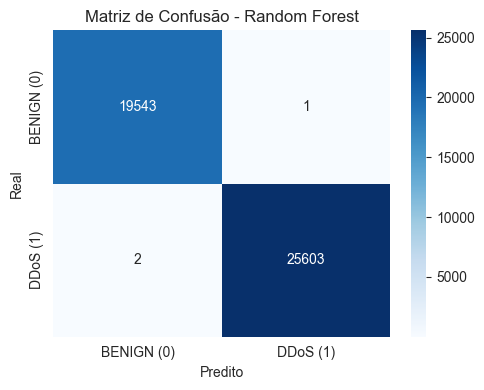

array([[19543,     1],
       [    2, 25603]])

In [13]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["BENIGN (0)", "DDoS (1)"],
            yticklabels=["BENIGN (0)", "DDoS (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Random Forest")
plt.tight_layout()
plt.show()

cm


In [14]:
print(classification_report(y_test, y_pred, target_names=["BENIGN", "DDoS"]))


              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19544
        DDoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



In [15]:
import joblib
import os


In [16]:
# Garantir que a pasta models exista
os.makedirs("../models", exist_ok=True)

model_path = "../models/random_forest_ddos.pkl"

joblib.dump(rf_clf, model_path)

print(f"Modelo salvo em: {model_path}")


Modelo salvo em: ../models/random_forest_ddos.pkl
